# Today's 

For my project I wanted to look at today's at the moment stock data and find out the top 5 largest stock by volume at the particular time and using yfinance get the information about those stocks and thru data visualization see how that stock is performing for the past year. I wanted to see when was the highest high, lowest low, when was the closing price of the data high n low as well as the opening price of the data. 


I am using yfinance which is built in on yahoo finance API for my analysis and for my visualisation I am using plotly as I am plotting interactive data.

In [2]:
import yfinance as yf
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import plotly.express as px

# to print current time and a day of the week and formatted
today = pd.Timestamp(datetime.datetime.today())
print(f"Today is {today.day_name()} {today.strftime('%m-%d-%y %H:%M:%S')} ")



Today is Sunday 03-19-23 01:34:05 


In [3]:
def convert_scale(value):
    if value.endswith('M'):
        return float(value[:-1]) * 10**6
    elif value.endswith('B'):
        return float(value[:-1]) * 10**9
    elif value.endswith('T'):
        return float(value[:-1]) * 10**12
    else:
        return float(value)


In [4]:
# unit test

'''def test_convert_scale_string():
    scale = convert_scale('test')
    print(scale)
    assert scale == 0
    '''
def test_convert_scale_negative():
    scale = convert_scale('-5')
    print(scale)
    assert scale == -5.0

'''def test_convert_scale_M():
    scale = convert_scale('K')
    print(scale)
    assert scale == 0'''

def test_convert_scale_M():
    scale = convert_scale('5M')
    print(scale)
    assert scale == 5000000

'''def test_convert_scale_B():
    scale = convert_scale(f)
    print(scale)
    assert scale == 0'''

def test_convert_scale_B():
    scale = convert_scale('2B')
    print(scale)
    assert scale == 2000000000


In [5]:
#test_convert_scale_string()
test_convert_scale_negative()
test_convert_scale_M()
test_convert_scale_B()



-5.0
5000000.0
2000000000.0


Region: United States, Market Cap (Intraday): Mid Cap and Large Cap and Mega Cap, Volume:greater than 5000000

## Feature 1: Loading Data
As per the requirement, 2 data sets to be loaded in. I decided to use pandas, read_html function which reads HTML tables into a list of DataFrame objects. I am reading in the tables from https://finance.yahoo.com/. From there, I am webscraping most-active, gainers and losers tables. 

In [6]:
# reading in from a website and getting only the 1st page
most_active = pd.read_html('https://finance.yahoo.com/most-active')[0]
print(most_active.shape) #shows the shape of table
most_active.head() #print first 5 rows
#most_active.loc[most_active.Name.str.contains('(?i)CORP', regex=True)]


(25, 10)


,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM),52 Week Range
0,LUMN,"Lumen Technologies, Inc.",2.48,-0.01,-0.40%,212.12M,35.051M,2.493B,NaN,NaN
1,FRC,First Republic Bank,23.03,-11.24,-32.80%,148.941M,13.761M,6.382B,3.78,NaN
2,CS,Credit Suisse Group AG,2.01,-0.15,-6.94%,132.034M,34.378M,8.556B,NaN,NaN
3,TSLA,"Tesla, Inc.",180.13,-4.00,-2.17%,133.197M,183.445M,569.949B,50.46,NaN
4,BAC,Bank of America Corporation,27.82,-1.15,-3.97%,129.87M,48.537M,222.54B,8.92,NaN


In [7]:
# reading in 2nd table
gainers = pd.read_html('https://finance.yahoo.com/gainers')[0]
print(gainers.shape)
gainers.head()


(25, 10)


,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM),52 Week Range
0,IMPJY,Webuild S.p.A.,4.05,0.71,+21.26%,41970,2303,1.994B,NaN,NaN
1,BAIDF,"Baidu, Inc.",17.56,1.96,+12.60%,45110,20975,44.059B,47.46,NaN
2,KDKWF,Kadokawa Corporation,20.07,2.07,+11.50%,20001,327,2.795B,18.76,NaN
3,MSTR,MicroStrategy Incorporated,267.66,26.58,+11.03%,1.985M,651656,2.784B,NaN,NaN
4,COIN,"Coinbase Global, Inc.",74.98,7.20,+10.62%,30.643M,18.728M,19.637B,7.67,NaN


In [8]:
# reading in 3rd table
losers = pd.read_html('https://finance.yahoo.com/losers')[0]
print(losers.shape)
losers.head()


(25, 10)


,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM),52 Week Range
0,FRC-PI,First Republic Bank,10.15,-5.47,-35.02%,787252,96590,6.399B,1.29,NaN
1,FRC-PH,First Republic Bank,9.36,-4.65,-33.19%,651323,81918,6.029B,1.19,NaN
2,FRC,First Republic Bank,23.03,-11.24,-32.80%,148.941M,13.761M,6.382B,3.78,NaN
3,GOCO,"GoHealth, Inc.",13.22,-4.28,-24.46%,141426,52410,2.841B,NaN,NaN
4,SRPT,"Sarepta Therapeutics, Inc.",122.69,-26.98,-18.03%,7.413M,1.334M,10.795B,NaN,NaN


## Feature 2: Clean and operate on the data while combining them.
Next requirement for the project is to combine the datasets to create new dataset and do analysis on it. By looking at the tables, I want to join, columns on all of them are same, thus pandas concat function works well for it. Concat function stacks the dataset on top of each other, thus to have a continuos index 'ignore_index=True' param is used. 
To clean the dataset, I created a custom function that converts 'M','B' &'T' into its corresponding 10^n values. Data also consists of NaN values, thus I dropped one column and replaced NaN values to 0, on another column as well as replaced % to ''.

In [9]:
# joining 3 datasets into 1 dataframe.
stocks_df = pd.concat([most_active, gainers, losers], ignore_index=True)
print(stocks_df.shape) # shows shape of new dataframe
print(f'Datatype before the change \n {stocks_df.info()}')
stocks_df.head() # prints top 5 rows



(75, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Symbol             75 non-null     object 
 1   Name               75 non-null     object 
 2   Price (Intraday)   75 non-null     float64
 3   Change             75 non-null     float64
 4   % Change           75 non-null     object 
 5   Volume             75 non-null     object 
 6   Avg Vol (3 month)  75 non-null     object 
 7   Market Cap         75 non-null     object 
 8   PE Ratio (TTM)     55 non-null     float64
 9   52 Week Range      0 non-null      float64
dtypes: float64(4), object(6)
memory usage: 6.0+ KB
Datatype before the change 
 None


,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM),52 Week Range
0,LUMN,"Lumen Technologies, Inc.",2.48,-0.01,-0.40%,212.12M,35.051M,2.493B,NaN,NaN
1,FRC,First Republic Bank,23.03,-11.24,-32.80%,148.941M,13.761M,6.382B,3.78,NaN
2,CS,Credit Suisse Group AG,2.01,-0.15,-6.94%,132.034M,34.378M,8.556B,NaN,NaN
3,TSLA,"Tesla, Inc.",180.13,-4.00,-2.17%,133.197M,183.445M,569.949B,50.46,NaN
4,BAC,Bank of America Corporation,27.82,-1.15,-3.97%,129.87M,48.537M,222.54B,8.92,NaN


Cleaning the dataframe:
Analyzing the data, I dropped '52 Week Range' column which consists of NaN values, fill in 0's where there was NaN values in 'PE Ratio (TTM)' column. Next up is converting the scale as well as changing the datatypes from object to float64 for 'Volume', 'Avg Vol (3 month)', 'Market Cap' columns. Regular expressions are handy when searching and cleaning text-based columns in Pandas. Finally, I replaced % to ' ' with a regex=True param and changed the datatype using pandas to_numeric function.

In [10]:
stocks_df['PE Ratio (TTM)'] = stocks_df['PE Ratio (TTM)'].fillna(0) # fill in 0 where NaN
stocks_df.dropna(axis=1, thresh=9, inplace=True) # drop a column

# using .apply function to convert the scale n datatypes
stocks_df['Volume'] = stocks_df['Volume'].apply(convert_scale) 
stocks_df['Avg Vol (3 month)'] = stocks_df['Avg Vol (3 month)'].apply(convert_scale)
stocks_df['Market Cap'] = stocks_df['Market Cap'].apply(convert_scale)

# replacing %:'' and changing the dtype of column
stocks_df['% Change'] = pd.to_numeric(stocks_df['% Change'].replace({'%' : ''}, regex=True))

print(f'Datatypes after the change: {stocks_df.info()}') # shows all the columns, non null count and dtypes
stocks_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Symbol             75 non-null     object 
 1   Name               75 non-null     object 
 2   Price (Intraday)   75 non-null     float64
 3   Change             75 non-null     float64
 4   % Change           75 non-null     float64
 5   Volume             75 non-null     float64
 6   Avg Vol (3 month)  75 non-null     float64
 7   Market Cap         75 non-null     float64
 8   PE Ratio (TTM)     75 non-null     float64
dtypes: float64(7), object(2)
memory usage: 5.4+ KB
Datatypes after the change: None


,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM)
0,LUMN,"Lumen Technologies, Inc.",2.48,-0.01,-0.40,212120000.0,35051000.0,2.493000e+09,0.00
1,FRC,First Republic Bank,23.03,-11.24,-32.80,148941000.0,13761000.0,6.382000e+09,3.78
2,CS,Credit Suisse Group AG,2.01,-0.15,-6.94,132034000.0,34378000.0,8.556000e+09,0.00
3,TSLA,"Tesla, Inc.",180.13,-4.00,-2.17,133197000.0,183445000.0,5.699490e+11,50.46
4,BAC,Bank of America Corporation,27.82,-1.15,-3.97,129870000.0,48537000.0,2.225400e+11,8.92
...,...,...,...,...,...,...,...,...,...
70,SNV,Synovus Financial Corp.,27.32,-2.56,-8.57,5424000.0,1498000.0,3.990000e+09,5.93
71,CMA,Comerica Incorporated,43.59,-4.02,-8.44,11654000.0,2581000.0,6.261000e+09,5.30
72,SPWR,SunPower Corporation,12.37,-1.13,-8.37,7542000.0,4188000.0,2.366000e+09,24.74
73,HALO,"Halozyme Therapeutics, Inc.",33.08,-2.99,-8.29,6674000.0,1389000.0,4.883000e+09,29.27


The pandas concat function stacks data sets on top of each other. Since, I am getting most_active, gainers and losers stock, most_active stocks could also be a gainer or a loser. Thus, I wanted to see if there is any duplicate rows. I used pandas duplicated() function to find such rows.

In [11]:
# find if there are any duplicated rows
duplicate = stocks_df[stocks_df.duplicated()]
duplicate

,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM)
52,FRC,First Republic Bank,23.03,-11.24,-32.80,148941000.0,13761000.0,6.382000e+09,3.78
64,USB,U.S. Bancorp,32.95,-3.41,-9.38,56387000.0,10700000.0,5.569600e+10,9.61


In [12]:
# if there is any duplicates drop_duplicates function will delete the rows, 
# keep='first' param keeps the first occurence and drops anything else. 
stocks_df.drop_duplicates(keep='first', inplace=True, ignore_index=True) # inplace= True would replace the original df 
print(stocks_df.shape) # prints updated shape of df
pd.set_option('display.max_rows', None) # displays all the rows
stocks_df # dispalys all the rows in a df


(73, 9)


,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM)
0,LUMN,"Lumen Technologies, Inc.",2.480,-0.010,-0.40,212120000.0,35051000.0,2.493000e+09,0.00
1,FRC,First Republic Bank,23.030,-11.240,-32.80,148941000.0,13761000.0,6.382000e+09,3.78
2,CS,Credit Suisse Group AG,2.010,-0.150,-6.94,132034000.0,34378000.0,8.556000e+09,0.00
3,TSLA,"Tesla, Inc.",180.130,-4.000,-2.17,133197000.0,183445000.0,5.699490e+11,50.46
4,BAC,Bank of America Corporation,27.820,-1.150,-3.97,129870000.0,48537000.0,2.225400e+11,8.92
5,F,Ford Motor Company,11.300,-0.520,-4.40,241383000.0,68075000.0,4.711700e+10,0.00
6,AAPL,Apple Inc.,155.000,-0.850,-0.55,98945000.0,71085000.0,2.465000e+12,25.96
7,AMD,"Advanced Micro Devices, Inc.",97.840,1.240,1.28,94081000.0,58824000.0,1.576580e+11,104.09
8,AMZN,"Amazon.com, Inc.",98.950,-1.090,-1.09,87300000.0,70076000.0,1.025000e+12,0.00
9,NVDA,NVIDIA Corporation,257.250,1.840,0.72,84855000.0,49212000.0,6.410670e+11,109.47


Data Analysis:



       Price (Intraday)     Change  % Change        Volume  Avg Vol (3 month)  \
count         73.000000  73.000000  73.00000  7.300000e+01       7.300000e+01   
mean          49.618562  -0.849110  -2.54863  3.595512e+07       1.514426e+07   
std           65.399883   6.233406  10.56943  4.922520e+07       2.690225e+07   
min            1.140000 -26.980000 -35.02000  1.917800e+04       3.270000e+02   
25%           11.320000  -2.230000  -8.80000  2.254000e+06       8.409480e+05   
50%           21.880000  -0.270000  -2.06000  1.148400e+07       3.982000e+06   
75%           50.840000   1.090000   5.85000  5.172400e+07       1.809900e+07   
max          279.430000  26.580000  21.26000  2.413830e+08       1.834450e+08   

         Market Cap  PE Ratio (TTM)  
count  7.300000e+01       73.000000  
mean   1.549622e+11       19.942055  
std    4.424164e+11       33.330301  
min    1.994000e+09        0.000000  
25%    3.627000e+09        0.000000  
50%    6.399000e+09        7.670000  
75% 

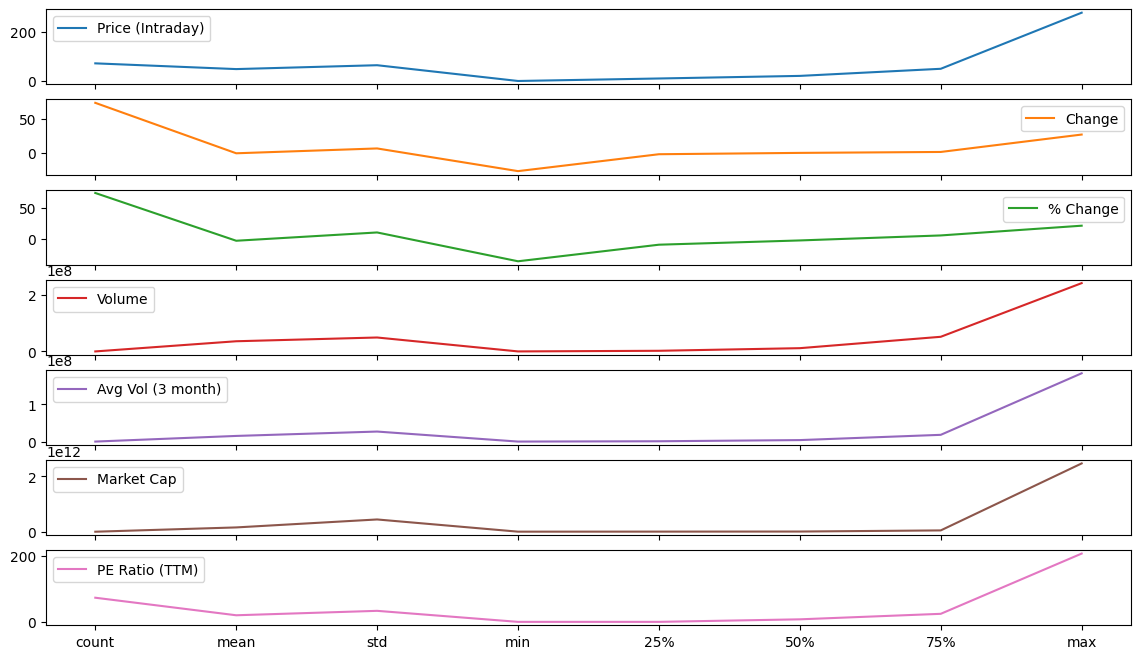

In [13]:

stocks_df.describe().plot(subplots=True, figsize=(14,8))
print(stocks_df.describe())

At the time of doing data analysis, Bank was a hot topic, thus I wanted to see how many bank stocks are in the list. By looking at data i noticed that some bank uses 'Banc' and some uses 'Bank', so to make it easier I searched for Ban. 

In [14]:
# find all rows that have 'Ban' in its name column?
stocks_df.loc[stocks_df.Name.str.contains('(?i)Ban', regex=True)]

,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM)
1,FRC,First Republic Bank,23.03,-11.24,-32.80,148941000.0,13761000.0,6.382000e+09,3.78
4,BAC,Bank of America Corporation,27.82,-1.15,-3.97,129870000.0,48537000.0,2.225400e+11,8.92
10,HBAN,Huntington Bancshares Incorporated,10.34,-0.64,-5.79,80447000.0,18099000.0,1.498900e+10,7.49
16,USB,U.S. Bancorp,32.95,-3.41,-9.38,56387000.0,10700000.0,5.569600e+10,9.61
18,NYCB,"New York Community Bancorp, Inc.",6.54,-0.32,-4.66,52654000.0,11780000.0,4.685000e+09,5.54
50,FRC-PI,First Republic Bank,10.15,-5.47,-35.02,787252.0,96590.0,6.399000e+09,1.29
51,FRC-PH,First Republic Bank,9.36,-4.65,-33.19,651323.0,81918.0,6.029000e+09,1.19
54,WAL,Western Alliance Bancorporation,31.32,-5.59,-15.14,24089000.0,4741000.0,4.046000e+09,3.34
59,NYCB-PA,"New York Community Bancorp, Inc.",15.65,-1.84,-10.52,476583.0,71291.0,2.676000e+09,12.84
63,ASB,Associated Banc-Corp,17.79,-1.75,-8.96,6523000.0,1705000.0,2.948000e+09,8.20


Get all the rows where volume is at least 20 million and the daily change is at least -5?

In [15]:
volume_change = stocks_df.query('Volume >= 20000000 and Change <= -5')
volume_change

,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM)
1,FRC,First Republic Bank,23.03,-11.24,-32.80,148941000.0,13761000.0,6.382000e+09,3.78
54,WAL,Western Alliance Bancorporation,31.32,-5.59,-15.14,24089000.0,4741000.0,4.046000e+09,3.34


Find stocks that dropped below 25% and print its symbol, name and % Change ?

In [16]:
stocks_df.query('`% Change` < -25')[['Symbol', 'Name', '% Change']]

,Symbol,Name,% Change
1,FRC,First Republic Bank,-32.80
50,FRC-PI,First Republic Bank,-35.02
51,FRC-PH,First Republic Bank,-33.19


In [17]:

Symbol_s = stocks_df.loc[(stocks_df['PE Ratio (TTM)']>=19) & (stocks_df['Change']<= -5) & (stocks_df['Symbol'].str.startswith('S')),['Symbol', 'Name']]
Symbol_s

,Symbol,Name


In order to filter a DataFrame column that has spaces with the query method, we wrap the column using backticks. While this may not look great, it does allow us to use any column in the method.

In [18]:
large_market_cap = stocks_df.query("`Market Cap` > 200000000000")
large_market_cap.head()



,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM)
3,TSLA,"Tesla, Inc.",180.13,-4.00,-2.17,133197000.0,183445000.0,5.699490e+11,50.46
4,BAC,Bank of America Corporation,27.82,-1.15,-3.97,129870000.0,48537000.0,2.225400e+11,8.92
6,AAPL,Apple Inc.,155.00,-0.85,-0.55,98945000.0,71085000.0,2.465000e+12,25.96
8,AMZN,"Amazon.com, Inc.",98.95,-1.09,-1.09,87300000.0,70076000.0,1.025000e+12,0.00
9,NVDA,NVIDIA Corporation,257.25,1.84,0.72,84855000.0,49212000.0,6.410670e+11,109.47


In [19]:
top_5_company = stocks_df.nlargest(5,['Volume'])
top_5_company


,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM)
5,F,Ford Motor Company,11.30,-0.52,-4.40,241383000.0,68075000.0,4.711700e+10,0.00
0,LUMN,"Lumen Technologies, Inc.",2.48,-0.01,-0.40,212120000.0,35051000.0,2.493000e+09,0.00
1,FRC,First Republic Bank,23.03,-11.24,-32.80,148941000.0,13761000.0,6.382000e+09,3.78
3,TSLA,"Tesla, Inc.",180.13,-4.00,-2.17,133197000.0,183445000.0,5.699490e+11,50.46
2,CS,Credit Suisse Group AG,2.01,-0.15,-6.94,132034000.0,34378000.0,8.556000e+09,0.00


In [20]:
top_5_volume = (top_5_company.Symbol).to_list()
top_5_volume

['F', 'LUMN', 'FRC', 'TSLA', 'CS']

In [21]:
ticker = yf.download(top_5_volume, period='1y',interval='1d', ignore_tz=True, progress=False, auto_adjust=False, actions='inline' )
ticker.info()
ticker.head()
pd.set_option('display.max_columns', None)
ticker.head()
#ticker.to_csv('ticker.csv')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2022-03-18 to 2023-03-17
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   (Adj Close, CS)       251 non-null    float64
 1   (Adj Close, F)        251 non-null    float64
 2   (Adj Close, FRC)      251 non-null    float64
 3   (Adj Close, LUMN)     251 non-null    float64
 4   (Adj Close, TSLA)     251 non-null    float64
 5   (Close, CS)           251 non-null    float64
 6   (Close, F)            251 non-null    float64
 7   (Close, FRC)          251 non-null    float64
 8   (Close, LUMN)         251 non-null    float64
 9   (Close, TSLA)         251 non-null    float64
 10  (Dividends, CS)       251 non-null    float64
 11  (Dividends, F)        251 non-null    float64
 12  (Dividends, FRC)      251 non-null    float64
 13  (Dividends, LUMN)     251 non-null    float64
 14  (Dividends, TSLA)     251 non-null    float64
 15  (Hig

Adj Close                                               Close  \
                  CS          F         FRC       LUMN        TSLA    CS   
Date                                                                       
2022-03-18  8.020674  15.438365  169.184082  10.612164  301.796661  8.15   
2022-03-21  8.010833  15.090405  166.524918  10.487765  307.053345  8.14   
2022-03-22  8.119087  15.648971  169.203918  10.487765  331.326660  8.25   
2022-03-23  7.961626  15.273540  163.349823  10.401643  333.036682  8.09   
2022-03-24  7.991150  15.410893  164.917526  10.420781  337.973328  8.12   

                                                     Dividends                 \
                    F         FRC   LUMN        TSLA        CS    F  FRC LUMN   
Date                                                                            
2022-03-18  16.860001  170.509995  11.09  301.796661       0.0  0.0  0.0  0.0   
2022-03-21  16.480000  167.830002  10.96  307.053345       0.0  0.0  0.0  0.0   
2022-03-22  17.090000  170.529999  10.96  331.326660       0.0  0.0  0.0  0.0   
2022-03-23  16.680000  164.630005  10.87  333.036682       0.0  0.0  0.0  0.0   
2022-03-24  16.830000  166.210007  10.89  337.973328       0.0  0.0  0.0  0.0   

                 High                                             Low  \
           TSLA    CS          F         FRC   LUMN        TSLA    CS   
Date                                                                    
2022-03-18  0.0  8.16  16.900000  171.500000  11.15  302.616669  7.91   
2022-03-21  0.0  8.19  17.110001  171.100006  11.25  314.283325  8.06   
2022-03-22  0.0  8.35  17.309999  174.210007  11.09  332.619995  8.23   
2022-03-23  0.0  8.20  17.049999  169.259995  11.14  346.899994  8.07   
2022-03-24  0.0  8.14  16.980000  167.089996  10.95  341.496674  8.01   

                                                      Open             \
                    F         FRC   LUMN        TSLA    CS          F   
Date                                                                    
2022-03-18  16.280001  166.289993  10.78  289.130005  7.91  16.420000   
2022-03-21  16.330000  165.800003  10.92  302.363342  8.16  16.870001   
2022-03-22  16.700001  168.570007  10.81  307.250000  8.24  16.719999   
2022-03-23  16.570000  163.529999  10.83  325.466675  8.09  16.820000   
2022-03-24  16.639999  163.899994  10.79  329.600006  8.05  16.740000   

                                          Stock Splits                      \
                   FRC   LUMN        TSLA           CS    F  FRC LUMN TSLA   
Date                                                                         
2022-03-18  168.500000  10.87  291.496674          0.0  0.0  0.0  0.0  0.0   
2022-03-21  170.369995  11.10  304.993347          0.0  0.0  0.0  0.0  0.0   
2022-03-22  169.449997  11.03  310.000000          0.0  0.0  0.0  0.0  0.0   
2022-03-23  168.309998  10.98  326.646667          0.0  0.0  0.0  0.0  0.0   
2022-03-24  164.330002  10.89  336.576660          0.0  0.0  0.0  0.0  0.0   

              Volume                                          
                  CS         F      FRC      LUMN       TSLA  
Date                                                          
2022-03-18   9640200  89144000  1494300  25454500  100414200  
2022-03-21  11540600  72583600   639700   9575900   81981600  
2022-03-22   8832500  77647100  1557500   9577000  105868500  
2022-03-23   7727800  63296800  1090600   7396500  120676200  
2022-03-24   7632100  56314200   888800   7265700   68920800

In [22]:
'''high_close = ticker[ticker[('Close', 'AAPL')] >= ticker[('High', 'AMZN')]]
high_close'''


"high_close = ticker[ticker[('Close', 'AAPL')] >= ticker[('High', 'AMZN')]]\nhigh_close"

## Feature 3: Visualize/Present your data.

In [23]:
close = ticker.Close
close.info()
close.head()
close.describe()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2022-03-18 to 2023-03-17
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CS      251 non-null    float64
 1   F       251 non-null    float64
 2   FRC     251 non-null    float64
 3   LUMN    251 non-null    float64
 4   TSLA    251 non-null    float64
dtypes: float64(5)
memory usage: 11.8 KB


,CS,F,FRC,LUMN,TSLA
count,251.000000,251.000000,251.000000,251.000000,251.000000
mean,4.974542,13.474143,138.252988,8.247968,235.104516
std,1.580604,1.558582,22.736885,2.929266,62.742564
min,2.010000,10.950000,23.030001,2.480000,108.099998
25%,3.480000,12.200000,123.220001,5.480000,190.924995
50%,5.070000,13.180000,140.880005,8.820000,233.000000
75%,5.920000,14.700000,154.089996,10.960000,288.360001
max,8.250000,17.750000,170.529999,12.500000,381.816681


In [24]:
fig = px.line(close, title=f"Top 5 Companies with largest volume on {today} for last 3y") 
fig.show()

                 CS             F           FRC          LUMN          TSLA
count  2.510000e+02  2.510000e+02  2.510000e+02  2.510000e+02  2.510000e+02
mean   2.103942e+07  6.408864e+07  4.275094e+06  2.036458e+07  1.080666e+08
std    3.162384e+07  2.479165e+07  1.958258e+07  2.373222e+07  4.965829e+07
min    6.607100e+06  1.298090e+07  4.135000e+05  5.334800e+06  4.186470e+07
25%    1.189090e+07  5.049385e+07  8.750500e+05  9.600050e+06  7.205490e+07
50%    1.565060e+07  5.878260e+07  1.221300e+06  1.573920e+07  9.215070e+07
75%    2.066315e+07  7.373620e+07  1.597750e+06  2.337870e+07  1.389452e+08
max    4.341040e+08  2.497841e+08  1.842469e+08  3.159433e+08  3.065906e+08


array([<AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>,
       <AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>,
       <AxesSubplot: xlabel='Date'>], dtype=object)

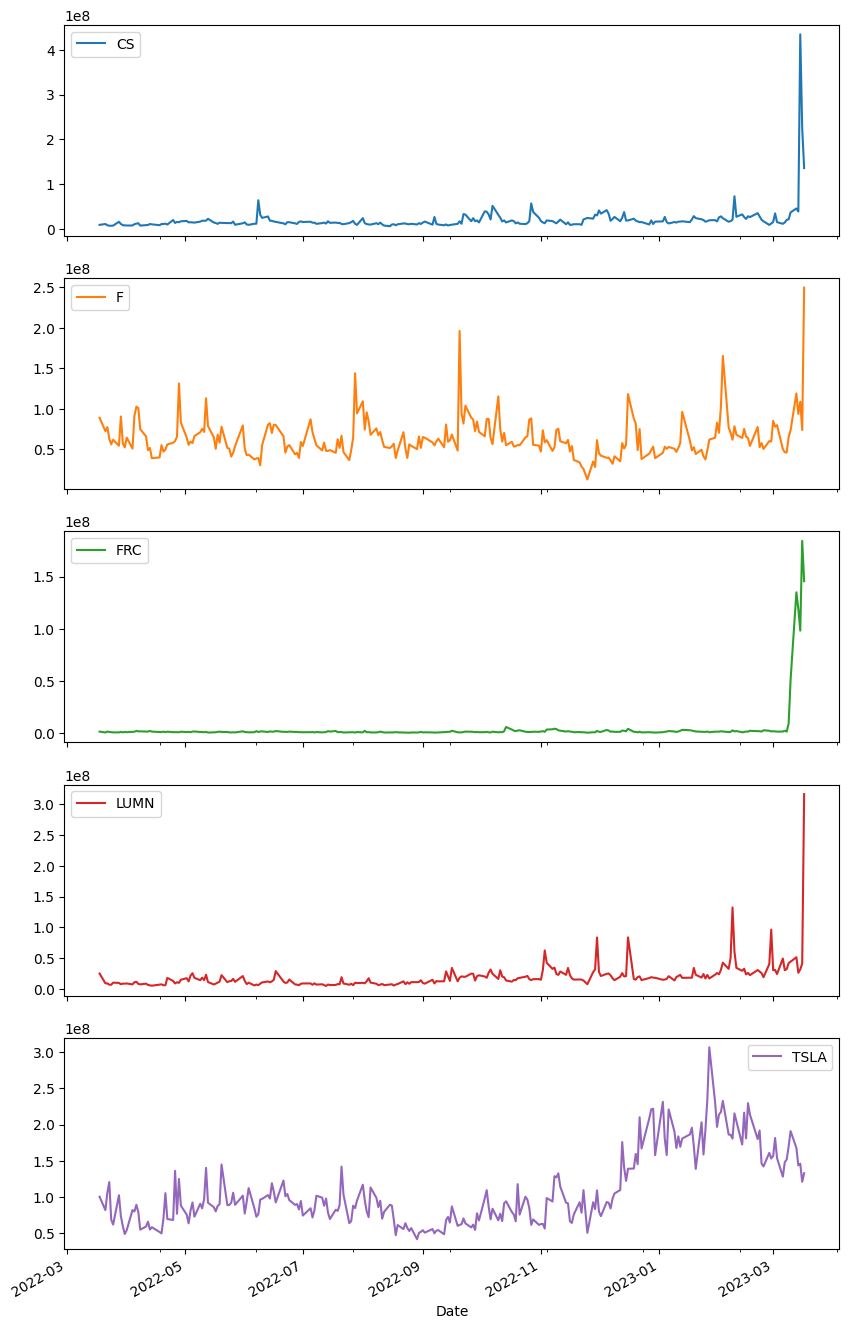

In [25]:
volume = ticker.Volume
volume

print(volume.describe())
volume.plot(subplots=True, figsize=(10,18))


In [26]:
high = ticker.High

figure = px.bar(high)
figure.show()

In [27]:
low = ticker.Low
figure = px.line(ticker.Low)
figure.show()

In [28]:
high1 = px.box(ticker.High)
high1.show()
high.describe()

,CS,F,FRC,LUMN,TSLA
count,251.000000,251.000000,251.000000,251.000000,251.000000
mean,5.058526,13.702430,140.454223,8.405578,241.383612
std,1.595258,1.580739,21.936594,2.943335,63.968727
min,2.100000,11.210000,30.010000,2.550000,111.750000
25%,3.530000,12.420000,125.219997,5.635000,195.809998
50%,5.160000,13.460000,142.429993,8.920000,239.316666
75%,6.000000,14.965000,155.860001,11.115000,296.699997
max,8.350000,17.799999,174.210007,12.540000,384.290009


In [29]:

dividend = ticker.Dividends
dividend



,CS,F,FRC,LUMN,TSLA
Date,,,,,
2022-03-18,0.000,0.00,0.00,0.00,0.0
2022-03-21,0.000,0.00,0.00,0.00,0.0
2022-03-22,0.000,0.00,0.00,0.00,0.0
2022-03-23,0.000,0.00,0.00,0.00,0.0
2022-03-24,0.000,0.00,0.00,0.00,0.0
2022-03-25,0.000,0.00,0.00,0.00,0.0
2022-03-28,0.000,0.00,0.00,0.00,0.0
2022-03-29,0.000,0.00,0.00,0.00,0.0
2022-03-30,0.000,0.00,0.00,0.00,0.0


In [30]:
High_Low = ticker.loc[:, ['High', 'Low' ]]
High_Low.head()
High_Low.max()
#High_Low.plot(subplots=True, figsize=(10,10))
#ax = High_Low.unstack(level=0).plot(figsize=(14,6))

High  CS        8.350000
      F        17.799999
      FRC     174.210007
      LUMN     12.540000
      TSLA    384.290009
Low   CS        8.230000
      F        17.200001
      FRC     168.570007
      LUMN     12.180000
      TSLA    362.433319
dtype: float64

## Feature 4: Best Practices.
Unit tests